## Entraînement de modèles uniclasse et multilabels

Sur la base des données assemblées sur le notebook `second_iteration_dataset.ipynb`

In [2]:
import pandas as pd
import swifter
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import load

import lightgbm as lgb

from sklearn.model_selection import train_test_split

from utils.map12_from_score_table import map12_from_score_table
import shap


%load_ext autoreload
%autoreload 2

features_sets = [
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list', 'age_ratio', 'index_ratio'], # Uniquement les infos de sélection
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list', 'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'age_ratio', 'index_ratio'], # Infos de sélections + de ventes
    [
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Sans les infos de sélection
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list',
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'has_image', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Sans les infos de vente
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list', 
       'product_group_name',
       'perceived_colour_value_name',
       'perceived_colour_master_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Uniquement certaines catégories
    ['in_pair_list',
       'in_repurchase_list', 'in_cross_list',
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 
       'index_name', 'index_group_name', 'section_name', 'garment_group_name',
       'total_purchases', 'average_quantity', 'average_price',
       'has_image', 'age_around_15_article', 'age_around_25_article',
       'age_around_35_article', 'age_around_45_article',
       'age_around_55_article', 'age_around_65_article', 'repurchases_article',
       'repurchase_interval', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_customer', 'repurchases_interval',
       'age_around_15_customer', 'age_around_25_customer',
       'age_around_35_customer', 'age_around_45_customer',
       'age_around_55_customer', 'age_around_65_customer', 'postal_code_group',
       'group', 'age_ratio', 'index_ratio'], # Toutes les infos
]

### 1. Modèle uniclasse - LightGBM


#### Préparation des données

In [2]:
data_uniclass = pd.read_pickle('pickles/second_iteration_data_train_uniclass.pkl')
data_uniclass.head(5)

customer_id  article_id  label  \
0  ed99cc34c86d4871bfddddc012f0ce2bac9ad14c7fc61f...  0714790020      0   
1  55b4916d32a641e3626a4da567bead084c62ca4ab97d58...  0871710001      0   
2  c9b428898d8353d2ae7470ef420b708825c13be2fecd41...  0935892001      0   
3  67852e732eda81a5f8e5661fe114e5ca17b870ba2df063...  0797710006      0   
4  0b423caa0ad781da963730635e7eac1c7653662ef8f7ee...  0923758001      0   

   in_pair_list  in_repurchase_list  in_cross_list product_code  \
0           100                 100             27      0714790   
1           100                 100             46      0871710   
2           100                 100             72      0935892   
3           100                 100             63      0797710   
4           100                 100             14      0923758   

                      prod_name product_type_name  product_group_name  ...  \
0              Mom Fit Ultra HW          Trousers  Garment Lower body  ...   
1            SPEED BRUNO  SHIRT             Shirt  Garment Upper body  ...   
2  LW (J) Conc PRICE SWEATSHIRT               Bra           Underwear  ...   
3              Teddy turtleneck               Top  Garment Upper body  ...   
4                       Vanessa           Unknown             Unknown  ...   

  age_around_15_customer age_around_25_customer age_around_35_customer  \
0                    0.0                    0.7                    0.3   
1                    0.2                    0.8                    0.0   
2                    0.5                    0.5                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

  age_around_45_customer age_around_55_customer age_around_65_customer  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.4                    0.6                    0.0   
4                    0.3                    0.7                    0.0   

  postal_code_group group age_ratio index_ratio  
0                 5     9  0.389226    0.300000  
1                 3     9  0.456370    0.222222  
2                 5     0  0.192645    0.933333  
3                 4     5  0.232025    0.846827  
4                 4     4  0.156613    0.717949  

[5 rows x 62 columns]

In [3]:
data_uniclass.sample(frac = 0.05).to_pickle('../streamlit/resources/lightgbm_train.pkl')

In [3]:
# Division du dataset en entraînement / validation
# Doit être fait par client afin de préserver le scoring MAP@12.
customers = data_uniclass['customer_id'].unique()

customers_train, customers_valid = train_test_split(customers, test_size=0.2)

data_train = data_uniclass[data_uniclass['customer_id'].isin(customers_train)]
data_valid = data_uniclass[data_uniclass['customer_id'].isin(customers_valid)]

data_train.sort_values('customer_id', inplace = True)
data_valid.sort_values('customer_id', inplace = True)

# Création des groupes pour l'application de la métrique MAP@12 dans lightGBM
groups_train = data_train.groupby('customer_id', sort = False)['customer_id'].count().values
groups_valid = data_valid.groupby('customer_id', sort = False)['customer_id'].count().values


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Recherche d'hyperparamètres

In [57]:

# Définition d'une classe contenant les valeurs possibles des paramètres.
class SearchableHyperparameters:

    def __init__(self):
        
        self.colsample_bytree = Real(low=0.4, high=0.6, prior='uniform',
                          name='colsample_bytree')
        
        self.feature_set  = Categorical(
            categories=[1, 2, 4],
            name='feature_set')
        
        
        self.min_child_samples = Integer(low=100, high=500,
                                       name='min_child_samples')
        
        self.min_child_weight = Categorical(
            categories=[1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            name='min_child_weight')
        
        self.num_leaves = Integer(low=6, high=50,
                                       name='num_leaves')
        
        
        self.objective = Categorical(
            categories=['binary', 'lambdarank', 'cross_entropy', 'cross_entropy_lambda'],
            name='objective')
        
        self.reg_alpha = Categorical(
            categories=[0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            name='reg_alpha')
        
        self.reg_lambda = Categorical(
            categories=[0, 1e-1, 1, 5, 10, 20, 50, 100],
            name='reg_lambda')
            
        self.subsample = Real(low=0.2, high=0.8, prior='uniform',
                          name='subsample')
        
        
        self.dimensions = [self.__getattribute__(attr)
                           for attr in dir(self) if '__' not in attr]
        
            
        self.default_parameters = [0.6, 2, 400, 1e-5, 35, 'lambdarank', 2, 20, 0.28]

searchable_params = SearchableHyperparameters()

In [10]:
# Création d'un dataframe pour enregistrer les paramètres
search_results = pd.DataFrame(columns = [])
search_results.to_pickle("pickles/second_iteration_search_results.pkl")

In [60]:

    
@use_named_args(dimensions=searchable_params.dimensions)
def search(**search_params):
    """Fonction d'entraînement du modèle. """
    global data_train, groups_train, data_valid, groups_valid, features_sets
    
    search_params['metric'] = 'map'
    search_params['eval_at'] = 12,
    
    print("Search params : ", search_params)
    
    feature_set = features_sets[search_params['feature_set']]
    
    params = search_params.copy()
    del params['feature_set']
    
    X_train = data_train[feature_set]
    Y_train = data_train['label']
    X_valid = data_valid[feature_set]
    Y_valid = data_valid['label']

    train_dataset = lgb.Dataset(X_train, label=Y_train, group = groups_train)
    validation_dataset = train_dataset.create_valid(X_valid, label = Y_valid, group = groups_valid)

    num_round = 1000
    bst = lgb.train(params, train_dataset, num_round, valid_sets=[validation_dataset], callbacks=[lgb.early_stopping(stopping_rounds=100)])
    
    preds = bst.predict(data_valid[feature_set])
    
    # Calculate MAP@12
    score_table = pd.concat([
        data_valid['customer_id'].reset_index(drop = True), 
        data_valid['label'].reset_index(drop = True), 
        pd.Series(preds).rename('prediction')
    ], axis = 1).sort_values(
        ['customer_id', 'prediction'], ascending = False
    )

    best_score = next(iter(bst.best_score['valid_0'].items()))[1]

    map12 = map12_from_score_table(score_table)['map12'].mean()
    
    # Sauvegarde du résultat dans le tableau.
    search_result_table = pd.read_pickle("pickles/second_iteration_search_results.pkl")
    
    new_row = []
    for key in search_params.keys():
        new_row.append(search_params[key])

    new_row.append(best_score)
    new_row.append(map12)
        
    new_row = pd.DataFrame([new_row], columns = [*search_params.keys(), 'best_score', 'map12'])
    search_result_table = pd.concat([search_result_table, new_row], axis = 0) 
    
    search_result_table.to_pickle("pickles/second_iteration_search_results.pkl")
    
    
    return -map12


In [ ]:
search_result = gp_minimize(
    func=search,
    dimensions=searchable_params.dimensions,
    n_calls=200,
    acq_func='EI',
    x0=searchable_params.default_parameters,
    verbose = True
)


In [9]:
search_results = pd.read_pickle("../streamlit/resources/lightgbm_hp_search.pkl")
search_results

colsample_bytree           Feature set  min_child_samples  \
0           0.600000               Minimal                100   
0           0.600000               Minimal                100   
0           0.600000               Minimal                100   
0           0.598968  No categorical infos                101   
0           0.541517  No categorical infos                223   
..               ...                   ...                ...   
0           0.538585  No categorical infos                198   
0           0.584714  No categorical infos                104   
0           0.460585  Main categories only                477   
0           0.532819  No categorical infos                143   
0           0.474357  Main categories only                123   

    min_child_weight  num_leaves  reg_alpha  reg_lambda  subsample  \
0            0.00001          50      100.0       100.0   0.800000   
0            0.00001          50      100.0       100.0   0.800000   
0            0.00001          50      100.0       100.0   0.800000   
0            0.00100          33       50.0       100.0   0.640160   
0         1000.00000          34        1.0        50.0   0.222712   
..               ...         ...        ...         ...        ...   
0          100.00000          39        0.0         5.0   0.279652   
0            0.00001          50      100.0       100.0   0.690131   
0           10.00000          49        0.0         1.0   0.218200   
0            1.00000          47        0.0        50.0   0.603327   
0          100.00000          48        0.0         0.0   0.258354   

               objective metric eval_at    map@12  Best score  
0                 binary    map   (12,)  0.108431         NaN  
0                 binary    map   (12,)  0.108431         NaN  
0                 binary    map   (12,)  0.109643         NaN  
0                 binary    map   (12,)  0.129240         NaN  
0                 binary    map   (12,)  0.127773         NaN  
..                   ...    ...     ...       ...         ...  
0                 binary    map   (12,)  0.132419    0.774953  
0   cross_entropy_lambda    map   (12,)  0.126357    0.768891  
0   cross_entropy_lambda    map   (12,)  0.133031    0.775565  
0   cross_entropy_lambda    map   (12,)  0.132731    0.775265  
0          cross_entropy    map   (12,)  0.132407    0.774941  

[442 rows x 13 columns]

In [14]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.9.7.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.10.0-11-amd64
Version          : #1 SMP Debian 5.10.92-1 (2022-01-18)
machine          : x86_64
processor        : 
byteorder        : little
LC_ALL           : None
LANG             : fr_FR.UTF-8
LOCALE           : fr_FR.UTF-8

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2021.3
dateutil         : 2.8.2
pip              : 21.2.4
setuptools       : 58.0.4
Cython           : 0.29.24
pytest           : 6.2.4
hypothesis       : None
sphinx           : 4.2.0
blosc            : None
feather          : None
xlsxwriter       : 3.0.1
lxml.etree       : 4.6.3
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.3
IPython          : 7.29.0
pandas_datareader: None
bs4              : 4.10.0
bottleneck       : 1.3.2
fsspec           : 2

#### Entraînement du modèle

In [ ]:
param = {
    'colsample_bytree': 0.49,
    'min_child_samples': 478,
    'min_child_weight': 10,
    'num_leaves': 18,
    'reg_alpha': 10,
    'reg_lambda': 100,
    'subsample': 0.7,
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': 12
}

feature_set = features_sets[4]

X_train = data_train[feature_set]
Y_train = data_train['label']
X_valid = data_valid[feature_set]
Y_valid = data_valid['label']

train_dataset = lgb.Dataset(X_train, label=Y_train, group = groups_train)
validation_dataset = train_dataset.create_valid(X_valid, label = Y_valid, group = groups_valid)

num_round = 1000
bst = lgb.train(param, train_dataset, num_round, valid_sets=[validation_dataset], callbacks=[lgb.early_stopping(stopping_rounds=500)])
    

In [55]:
next(iter(bst.best_score['valid_0'].items()))[1]

0.7684606149405606

In [26]:
# Matrice croisée
ypred = bst.predict(X_valid)
prediction = pd.Series(ypred)

pd.crosstab(Y_valid.reset_index(drop = True), ypred > 0.5, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite   False   True
Classe réelle                
0               341293  19057
1                 5102   2123

In [27]:
bst.save_model("models/seconde-iteration-lightgbm.txt")

#### Interprétation et performance du modèle

In [2]:
bst = lgb.Booster(model_file = "models/seconde-iteration-lightgbm.txt")

data_uniclass = pd.read_pickle('pickles/second_iteration_data_train_uniclass.pkl')

feature_set = features_sets[4]

features = data_uniclass[feature_set]



In [3]:
# Entraînement sur l'ensemble des données de test et création de la liste des recommandations.
preds_raw = bst.predict(features)

predictions = pd.Series(preds_raw).rename('prediction')

score_list = pd.concat([data_uniclass[['customer_id', 'label', 'article_id']], predictions], axis = 1)
score_list = score_list.sort_values(['customer_id', 'prediction'], ascending = False)
score_list = score_list.groupby('customer_id', sort = False, as_index = False).agg(
    prediction = ('article_id', lambda x: list(x)[0:12]),
    nb_purchases = ('label', 'sum')
)

In [4]:
# Création d'un label décrivant si la prédiction est bonne ou non.
data_uniclass = data_uniclass.merge(score_list, on = "customer_id", how = "left")

In [5]:
data_uniclass['is_right'] = data_uniclass.swifter.apply(
    lambda x: 
    1 if ((x.label == 1) & (x.article_id in x.prediction)) | ((x.label == 0) & (x.article_id not in x.prediction))
    else 0
, axis = 1)

Pandas Apply: 100%|██████████| 1843701/1843701 [00:46<00:00, 40070.70it/s]


In [6]:
# Rajout de la position dans la liste
data_uniclass['position_in_prediction'] = data_uniclass.swifter.apply(
    lambda x: 
        x.prediction.index(x.article_id) if x.article_id in x.prediction
        else 0
, axis = 1)

Pandas Apply: 100%|██████████| 1843701/1843701 [00:26<00:00, 68589.21it/s]


In [44]:
data_uniclass['class'] = 0
data_uniclass.loc[(data_uniclass['is_right'] == 1) & (data_uniclass['label'] == 1),'class'] = 4 # Vrais positifs
data_uniclass.loc[(data_uniclass['is_right'] == 0) & (data_uniclass['label'] == 0),'class'] = 2 # Faux positifs
data_uniclass.loc[(data_uniclass['is_right'] == 0) & (data_uniclass['label'] == 1),'class'] = 1 # Faux négatifs

In [48]:
# On enlève les vrai négatifs de l'analyse + les 8 premiers éléments représentent ~90% du score
data_to_analyze = data_uniclass[
    (data_uniclass['class'] != 0) &
    ((data_uniclass['class'] != 2) | (data_uniclass['position_in_prediction'] < data_uniclass['nb_purchases']))
]

# On rajoute la notion de début / fin de classement
top_rank_threshold = 1
data_to_analyze['rank_class'] = data_to_analyze['class']
data_to_analyze.loc[
    (data_to_analyze['class'] == 2) & 
    (data_to_analyze['position_in_prediction'] < top_rank_threshold),
    'rank_class'
] = 3 # Faux positifs en top position
data_to_analyze.loc[
    (data_to_analyze['class'] == 4) & 
    (data_to_analyze['position_in_prediction'] < top_rank_threshold),
    'rank_class'
] = 5 # Vrais positifs en top position

# One-hot encoding des catégories pour pouvoir utiliser les données dans un DecisionTree
from utils.dummify import Dummify

dummify = Dummify()

features = dummify.transform(data_to_analyze[features_sets[4]])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

explainer = DecisionTreeClassifier(max_depth=4, min_samples_leaf=2000)
explainer.fit(features, data_to_analyze['rank_class'])

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2000)

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = explainer.predict(features)
print(classification_report(data_to_analyze['rank_class'], y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      9333
           2       0.59      0.70      0.64     25888
           3       0.49      0.57      0.53     26818

    accuracy                           0.54     62039
   macro avg       0.36      0.42      0.39     62039
weighted avg       0.46      0.54      0.49     62039



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


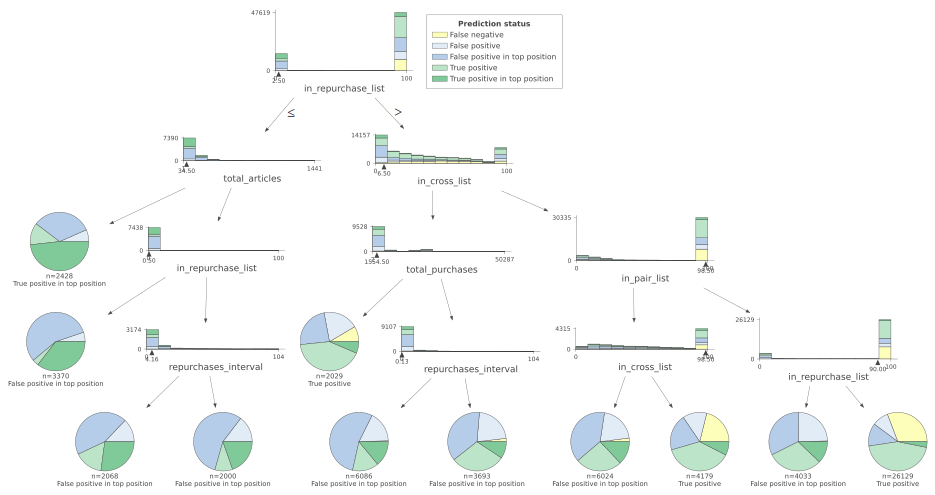

In [50]:
from dtreeviz.trees import dtreeviz # remember to load the package


class_colors = [None, # 0 classes
                None, # 1 class
                ["#FEFEBB","#a1dab4"], # 2 classes
                ["#ff0000","#00ff00",'#0000ff'], # colors were changed here
                ["#FEFEBB","#D9E6F5",'#a1dab4','#fee090'], # 4
                ["#FEFEBB", "#e2ecf7", '#b5cde8','#bce4c9','#80ca99'], # 5
                ["#FEFEBB",'#c7e9b4','#41b6c4','#2c7fb8','#fee090','#f46d43'], # 6
                ["#FEFEBB",'#c7e9b4','#7fcdbb','#41b6c4','#225ea8','#fdae61','#f46d43'], # 7
                ["#FEFEBB",'#edf8b1','#c7e9b4','#7fcdbb','#1d91c0','#225ea8','#fdae61','#f46d43'], # 8                                       ["#FEFEBB",'#c7e9b4','#41b6c4','#74add1','#4575b4','#313695','#fee090','#fdae61','#f46d43'], # 9
                ["#FEFEBB",'#c7e9b4','#41b6c4','#74add1','#4575b4','#313695','#fee090','#fdae61','#f46d43','#d73027'] # 10
]
viz = dtreeviz(explainer, features, data_to_analyze['rank_class'],
                target_name="Prediction status",
                feature_names=features.columns,
                colors = {'classes': class_colors},
                class_names=['False negative', 'False positive', 'False positive in top position', 'True positive', 'True positive in top position']
            )

viz

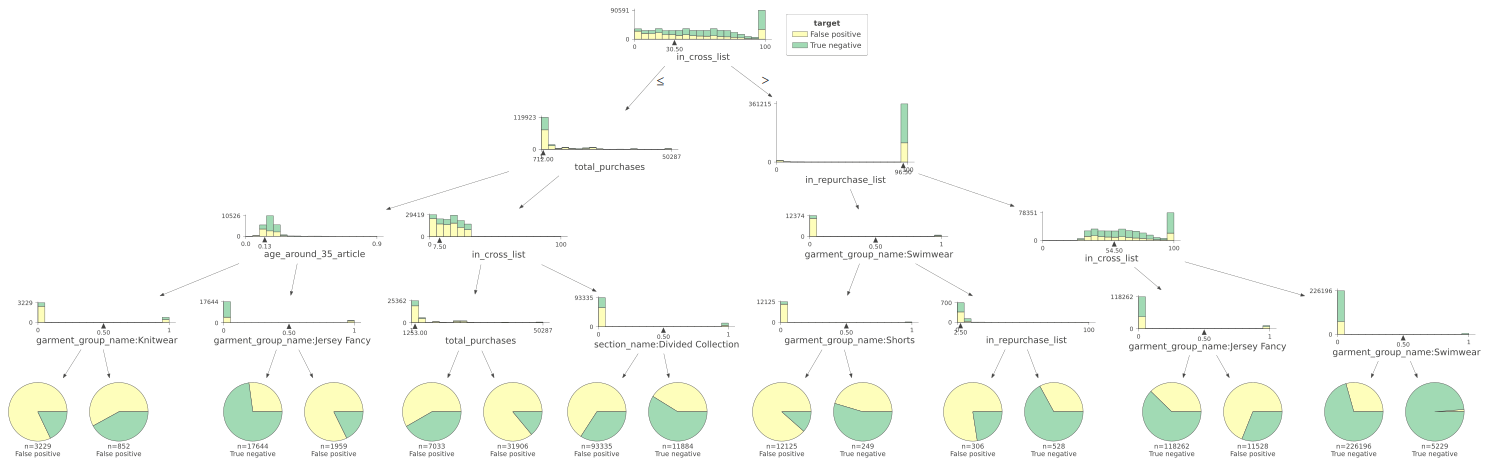

In [57]:
viz

### Soumission de la liste

### Entraînement sur jeu de données multilabel

In [3]:
data_multiclass = pd.read_pickle('pickles/second_iteration_data_train_multilabel.pkl')

In [4]:
categories = ['club_member_status', 'fashion_news_frequency', 'club_member_status', 'FN']

categories_article = ["product_type_name", "product_group_name", 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']

for category in categories_article:
    categories += [f"{category}"]
    
    for i in range(1, 50):
        categories += [f"{category}_{i}"]


#for category in categories:
#    data_multiclass[category] = data_multiclass[category].astype('category')
    
data_multiclass.drop(columns = categories, axis = 1, inplace = True)

In [7]:
data_train, data_valid = train_test_split(data_multiclass, test_size=0.2)

data_train.reset_index(drop = True, inplace = True)
data_valid.reset_index(drop = True, inplace = True)

In [8]:
not_features_columns = ['customer_id', 'article_id', 'purchased_list', 'cross_list', 'pair_list', 'repurchase_list', 'shortlist', 'shortlist_length', 'postal_code'] + [f"article_id_{i}" for i in range(0, 50)] + [f"{i}_label" for i in range(0, 50)]
labels_columns = [f"{i}_label" for i in range(0, 50)]

X_train = data_train.drop(not_features_columns, axis = 1)
Y_train = data_train[labels_columns]
X_valid = data_valid.drop(not_features_columns, axis = 1)
Y_valid = data_valid[labels_columns]

In [9]:
### CHECKPOINT
X_train.to_pickle('pickles/data_multilabel_train_X.pkl')
X_valid.to_pickle('pickles/data_multilabel_valid_X.pkl')
Y_train.to_pickle('pickles/data_multilabel_train_Y.pkl')
Y_valid.to_pickle('pickles/data_multilabel_valid_Y.pkl')
data_train.to_pickle('pickles/data_multilabel_train.pkl')
data_valid.to_pickle('pickles/data_multilabel_valid.pkl')

In [2]:
import pandas as pd 
import xgboost as xgb 

X_train = pd.read_pickle('pickles/data_multilabel_train_X.pkl')
X_valid = pd.read_pickle('pickles/data_multilabel_valid_X.pkl')
Y_train = pd.read_pickle('pickles/data_multilabel_train_Y.pkl')
Y_valid = pd.read_pickle('pickles/data_multilabel_valid_Y.pkl')
data_train = pd.read_pickle('pickles/data_multilabel_train.pkl')
data_valid = pd.read_pickle('pickles/data_multilabel_valid.pkl')

In [10]:
score_chunks = []
import time

for i in range(0, 50):
    print(f"Processing label {i}")
    
    train = xgb.DMatrix(data=X_train, label=Y_train[f"{i}_label"], enable_categorical = True)
    valid = xgb.DMatrix(data=X_valid, label=Y_valid[f"{i}_label"], enable_categorical = True)
    
    params = {'booster': 'gbtree', 'learning_rate': 0.05, 'objective': 'binary:logistic'}
    xgb1 = xgb.train(params = params, dtrain = train, num_boost_round=200, evals=[(train, 'train'), (valid, 'eval')])
    
    prediction = pd.Series(xgb1.predict(valid)).rename('prediction')
    labels = Y_valid[f"{i}_label"].rename('label')
    
    score_chunks.append(
        pd.concat([data_valid['customer_id'], labels, prediction], axis = 1)
    )
    
    time.sleep(2)


Processing label 0


/home/treb/anaconda3/lib/python3.9/site-packages/xgboost/data.py:273: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]


[13:53:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.64542	eval-logloss:0.64547
[1]	train-logloss:0.60228	eval-logloss:0.60233
[2]	train-logloss:0.56302	eval-logloss:0.56311
[3]	train-logloss:0.52720	eval-logloss:0.52732
[4]	train-logloss:0.49439	eval-logloss:0.49453
[5]	train-logloss:0.46423	eval-logloss:0.46441
[6]	train-logloss:0.43646	eval-logloss:0.43665
[7]	train-logloss:0.41080	eval-logloss:0.41103
[8]	train-logloss:0.38705	eval-logloss:0.38732
[9]	train-logloss:0.36503	eval-logloss:0.36532
[10]	train-logloss:0.34457	eval-logloss:0.34490
[11]	train-logloss:0.32553	eval-logloss:0.32590
[12]	train-logloss:0.30778	eval-logloss:0.30819
[13]	train-logloss:0.29123	eval-logloss:0.29168
[14]	train-logloss:0.27577	eval-logloss:0.27627
[15]	train-logloss:0.26131	eval-loglos

In [11]:
score_list = pd.concat(score_chunks)

In [16]:
from utils.map12_from_score_table import map12_from_score_table

map12 = map12_from_score_table(score_list)

print("Score MAP@12: ", map12['map12'].sum() / len(map12))

/var/www/datascientest/pyhm/utils/map12_from_score_table.py:29: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: np.sum(


Score MAP@12:  0.014230433695044155


## Prédiction sur les données de test

In [7]:
from utils.list_to_uniclass import ListToUniclass
from utils.add_uniclass_features import AddUniclassFeatures

In [8]:

data_test = pd.read_pickle('pickles/articles_list_test.pkl')
data_test.head()

customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                                          cross_list  \
0  [0751471001, 0915529003, 0928206001, 057308504...   
1  [0924243001, 0918522001, 0924243002, 090937000...   
2  [0918522001, 0924243001, 0866731001, 092424300...   
3  [0866731001, 0852584001, 0791587001, 091829200...   
4  [0924243001, 0930380001, 0928206001, 091060100...   

                                    repurchase_list  \
0                                                     
1                          [0351484002, 0826211002]   
2                                                     
3                                                     
4  [0927530004, 0896152002, 0730683050, 0791587015]   

                                           pair_list  \
0  [0805000001, 0877278002, 0673396002, 082557900...   
1  [0805406003, 0573085042, 0542402001, 079246900...   
2  [0727808002, 0858883001, 0699080001, 068581300...   
3                                                      
4  [0732206001, 0896152001, 0791587001, 092753000...   

                                           shortlist  
0  [0805000001, 0877278002, 0673396002, 082557900...  
1  [0351484002, 0826211002, 0805406003, 057308504...  
2  [0727808002, 0858883001, 0699080001, 068581300...  
3  [0866731001, 0852584001, 0791587001, 091829200...  
4  [0927530004, 0896152002, 0730683050, 079158701...

In [9]:
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
list_to_uniclass = ListToUniclass()
add_uniclass_features = AddUniclassFeatures(articles, customers)

submission = customers[['customer_id']]
data_test['purchase_list'] = ''

In [ ]:
# Génération de la cross-list par blocs de 50 000 clients.
import gc

length = len(data_test)
index = 0
chunks = []
rows_by_block = 10000

while index < length:
    print (f"\rTraitement des lignes {index} - {index + rows_by_block}              ")
    
    dataset = list_to_uniclass.transform(data_test.loc[index : min(index + rows_by_block, length) - 1])
    dataset = add_uniclass_features.transform(dataset)

    features = dataset.drop(columns = columns_to_drop, axis = 1)
    
    preds_raw = bst.predict(features)
    
    predictions = pd.Series(preds_raw).rename('prediction')
    
    score_list = pd.concat([dataset[['customer_id', 'article_id']], predictions], axis = 1)
    score_list = score_list.sort_values(['customer_id', 'prediction'], ascending = False)
    score_list = score_list.groupby('customer_id', sort = False, as_index = False).agg(
        prediction = ('article_id', lambda x: list(x))
    )
    score_list['prediction'] = score_list['prediction'].apply(lambda x: ' '.join(x[0: 12]))
    
    score_list.to_pickle(f'pickles/temp/test_prediction_{index}-{index + rows_by_block}.pkl')
    
    chunks.append(score_list)
    
    index += rows_by_block
    
    del features
    del dataset
    del preds_raw
    del predictions
    
    gc.collect()
    

In [16]:
for i in range(0, len(chunks)):
    chunks[i].to_pickle(f'pickles/temp_test_prediction_{i + 28}.pkl')

In [18]:
score_list = pd.concat(chunks)

In [20]:
submission = customers[['customer_id']]
submission = submission.merge(score_list, on = 'customer_id', how = 'left')


In [21]:
submission.to_csv('submissions/submission_lightgbm.csv', index=None)

## Conclusion
- Globalement l'approche uniclasse semble mieux fonctionner que l'approche multiclasse, à la fois en résultat et en temps de calcul.
- L'approche ML classique ne semble pas donner de résultat satisfaisants. En particulier la précision est à peine de 2%
- En changeant le nombre de round de boost et la proportion d'échantillons négatifs, **le meilleur score MAP@12 obtenu est de 0.024**.
- Une approche par KMeans ou régression linéaires (avec features polynomiales) serait éventuellement envisageable, mais les recherches précédentes tendent à montrer que ce qui manque à la prédiction a plutôt à voir avec des notions séquentielles et temporelles. 

**Nous pensons donc qu'il est pertinent de continuer avec des modèles de type RNN et GNN plutôt que de tenter de choisir et d'optimiser un modèle classique.**